# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [14]:
import VERT_FSFB3

In [15]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [16]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [17]:
SSH = G/g

In [18]:
Z_mid_uniform  = gsw.z_from_p(np.append(0, Pmid), lat = laty)

In [19]:
MODE = G.shape[-1]

In [20]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

### Beta plane paramters

In [21]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 15 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 30 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode:

In [22]:
MModes = 5 # 
wavelength = np.array([2e5, 1e5, .5e5]) # 200km, 100km, 50km
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # wavenumber
Rm = wavespeed[:MModes] / f0 # Rossby deformation radius
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber
freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn]) / (k_n[nn] ** 2 + l_n[nn] ** 2 + Rm[mm] ** (-2))
Amp = np.random.rand(2, MModes, len(wavelength))
M = Amp.size

#### SWOT swath: two 50km swaths with 20 km gap in middle

In [23]:
a, b, c, d = 0, 1, 50, 1
x0 = np.arange(0, 50, 1)
y0 = np.arange(0, 50, 1)
xswath_index0 = a + b * x0
yswath_index0 = c + d * y0
swath_ysize = 12
yswath_index = np.ma.masked_all([12, len(yswath_index0)])
xswath_index = np.ma.masked_all([12, len(xswath_index0)])
for yy in range(1, swath_ysize):
    if(yy!= 6&7):
        yswath_index[yy] = yswath_index0 + yy
        xswath_index[yy] = xswath_index0

In [63]:
yswath_index = np.ma.masked_outside(yswath_index, 0, 99)
y_mask = np.ma.getmask(yswath_index)
xswath_index = np.ma.MaskedArray(xswath_index, y_mask)

#### Retrieve valid data and random sample in time 

In [64]:
yvalid_index = yswath_index.compressed().astype(int) # retrieve the valid data 
xvalid_index = xswath_index.compressed().astype(int) # retrieve the valid data 
tindex = np.random.randint(low = 0, high= 99, size= xvalid_index.size)  # Random sampling in time

In [65]:
N = yvalid_index.size
N == xvalid_index.size

True

In [66]:
X_loc = np.arange(0, 1e6, 1e4)[xvalid_index] # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, 1e4)[yvalid_index]
T_time = np.arange(0, 1e10, 1e8)[tindex] # seconds, Time step : ~11days

### H Matrix and SSH

### Construct model in vector space

In [67]:
%%time
N_data = N
H_cos = np.zeros([N_data, MModes, len(wavelength)]) # Number of waves * Number of data
H_sin = np.zeros([N_data, MModes, len(wavelength)])
SSH_MN = np.ma.masked_all([N_data, MModes, len(wavelength)])
for tt in range(N_data):
    for mm in range(Amp.shape[1]):
        for nn in range(len(k_n)):
            H_cos[tt, mm, nn] = Psi[0, mm] * np.cos(k_n[nn] * X_loc[tt] + l_n[nn] * Y_loc[tt] + freq_n[nn, mm] * T_time[tt]) 
            H_sin[tt, mm, nn] = Psi[0, mm] * np.sin(k_n[nn] * X_loc[tt] + l_n[nn] * Y_loc[tt] + freq_n[nn, mm] * T_time[tt])

CPU times: user 45 ms, sys: 1.51 ms, total: 46.5 ms
Wall time: 46.1 ms


In [68]:
for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_MN[ :, mm, nn] = Amp[0, mm, nn] * H_cos[ :, mm, nn] + Amp[1, mm, nn] * H_sin[:, mm, nn]

SSH = SSH_MN.sum(axis = (-1, -2))

IIndex = np.zeros(N_data) # N: Number of y data
Y_v = np.zeros(N_data) 
H_v = np.zeros([N_data, M]) # M: number of model

for iii in range(N_data):
    Y_v[iii] = SSH[iii]
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[iii, mm, nn]
            H_v[iii, JIndex + 1] = H_sin[iii, mm, nn]

### Exact-solution - Solve 30 unknow amplitudes with 30 data points.

#### Weighted least square solution

#### R and P Matrix

In [69]:
R_ = np.eye(N, N)

In [70]:
P_ = np.eye(M, M)

In [71]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [72]:
A = np.matmul(H_v.T, LA.inv(R_))

In [73]:
HRH = np.matmul(A, H_v)

In [74]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

#### if the Eigenvalues of HRH are -->0, the problem is poorly conditioned. Otherwise, the problem is well conditioned.

In [75]:
eig, vec = LA.eig(HRH)
eig.real

array([26480.69666033, 22069.03534576, 18762.31329689, 18364.17348838,
       17049.90250156, 15483.60799742,  6375.86962646,  6304.80202318,
        5436.96978126,  5156.37831222,  4724.52754825,  4470.14853281,
        4100.3012325 ,  3807.3961861 ,  3754.56305575,  3558.65816727,
          86.15754496,    94.22165164,  1808.16582951,  1723.85698131,
        1335.75518557,  1611.04812347,  1588.39536313,  1535.68126453,
         517.30266351,   617.50602659,   663.5061394 ,   688.97920503,
         794.58706274,   751.99485214])

#### Soution with noise

In [76]:
X_ = np.matmul(D, Y_v)

In [77]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

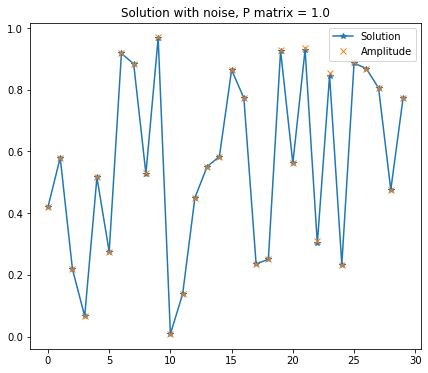

In [78]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(Amp.reshape([30], order = 'F'),'x',label = 'Amplitude')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'.png')

In [79]:
diff = SOL_WN - Amp.reshape([M], order = 'F')

In [80]:
rms = np.sqrt(np.mean(diff**2))
rms

0.0027062606852676124

#### Create simulated roll error

In [81]:
alpha2 = -1e-5
roll_err = np.ma.masked_all(yswath_index.shape)
xc = np.ma.masked_all(yswath_index.shape)
ac, al = roll_err.shape
for xx in range(ac):
    xc[xx, :] = (xx - (ac-1)/2) 
    roll_err[xx, :] = alpha2 * xc[xx, :] * 1e4 #10km resolution

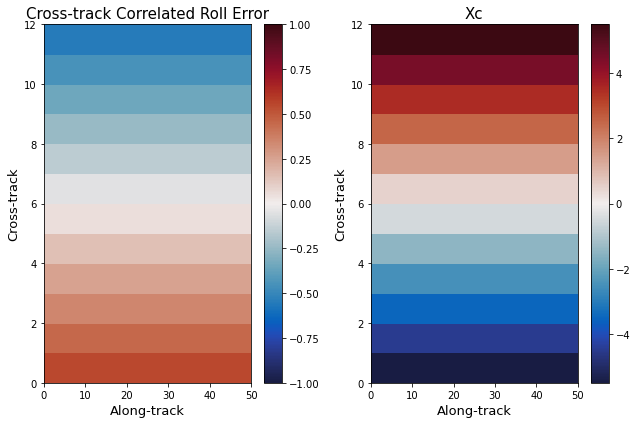

In [82]:
plt.figure(figsize = (9, 6))
plt.subplot(121)
plt.pcolor(roll_err, cmap = cmo.cm.balance, vmin = -1, vmax = 1)
plt.colorbar()
plt.xlabel('Along-track', fontsize = 13)
plt.ylabel('Cross-track', fontsize = 13)
plt.title('Cross-track Correlated Roll Error', fontsize = 15)

plt.subplot(122)
plt.pcolor(xc, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Along-track', fontsize = 13)
plt.ylabel('Cross-track', fontsize = 13)
plt.title('Xc', fontsize = 15)
plt.tight_layout()
plt.savefig('Cross_track_Correlated_Roll_Error.png', dpi = 100)

In [83]:
roll_err_masked = np.ma.MaskedArray(roll_err, y_mask)
xc_masked = np.ma.MaskedArray(xc, y_mask)

In [84]:
roll_err_valid = roll_err_masked.compressed().astype(int) # retrieve the valid data 
xc_valid = xc_masked.compressed().astype(int) # retrieve the valid data 

#### Add simple roll error to SSH

In [85]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M+1]) # M: number of model
nx, ny = N, N
for iii in range(N):
    Y_v[iii] = SSH[iii] + roll_err_valid[iii]
    H_v[iii, -1] = xc_valid[iii] # distance from nadir Xc 
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[iii, mm, nn]
            H_v[iii, JIndex + 1] = H_sin[iii, mm, nn]

#### Weighted least square solution

#### R and P Matrix

In [86]:
R_ = np.eye(N, N)

In [87]:
P_ = np.eye(M+1, M+1)

In [88]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M + 1):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [89]:
A = np.matmul(H_v.T, LA.inv(R_))

In [90]:
HRH = np.matmul(A, H_v)

In [91]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [92]:
HRH.shape, LA.inv(P_).shape

((31, 31), (31, 31))

In [93]:
eig, vec = LA.eig(HRH)
eig.real

array([3.65080709e+05, 2.63692275e+04, 2.20465089e+04, 1.86213342e+04,
       1.81971984e+04, 1.69749594e+04, 1.54820572e+04, 6.37583753e+03,
       6.30448520e+03, 5.43692782e+03, 5.15632369e+03, 4.71902383e+03,
       4.46896708e+03, 4.10029725e+03, 3.79314726e+03, 3.74230361e+03,
       3.55857651e+03, 8.61342856e+01, 9.40221089e+01, 1.80764572e+03,
       1.72255902e+03, 1.61103858e+03, 1.58835022e+03, 1.53525163e+03,
       1.32744500e+03, 5.17162489e+02, 6.09653903e+02, 6.63246542e+02,
       6.83890956e+02, 7.93923285e+02, 7.48293362e+02])

#### Soution with noise

In [94]:
X_ = np.matmul(D, Y_v)

In [95]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

In [96]:
AMP_alpha2 = np.append(Amp.reshape([30], order = 'F'), alpha2)

In [97]:
AMP_alpha2[-1], SOL_WN[-1], SOL_WN[-1] - AMP_alpha2[-1]

(-1e-05, 4.241247514891709e-06, 1.424124751489171e-05)

In [98]:
AMP_alpha2[:], SOL_WN[:]

(array([ 4.19902415e-01,  5.79811658e-01,  2.18944281e-01,  6.61229220e-02,
         5.16187788e-01,  2.75172621e-01,  9.17934185e-01,  8.84895630e-01,
         5.29414480e-01,  9.69558759e-01,  8.66361753e-03,  1.37828088e-01,
         4.49957859e-01,  5.51283547e-01,  5.83421537e-01,  8.64538042e-01,
         7.73645967e-01,  2.35383381e-01,  2.50641017e-01,  9.28228170e-01,
         5.63377348e-01,  9.36082870e-01,  3.09360237e-01,  8.55970411e-01,
         2.32700607e-01,  8.89194698e-01,  8.68896674e-01,  8.05339325e-01,
         4.76376655e-01,  7.73574245e-01, -1.00000000e-05]),
 array([4.19809084e-01, 5.79779362e-01, 2.18807473e-01, 6.61699482e-02,
        5.16003926e-01, 2.75253818e-01, 9.17615179e-01, 8.84358006e-01,
        5.28321325e-01, 9.67944005e-01, 8.54211956e-03, 1.37918218e-01,
        4.49889286e-01, 5.51116955e-01, 5.83375090e-01, 8.64327290e-01,
        7.73283913e-01, 2.35494791e-01, 2.50661647e-01, 9.26358609e-01,
        5.62127021e-01, 9.29629492e-01, 3.01803

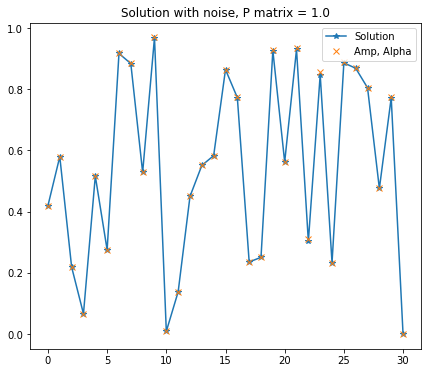

In [60]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(AMP_alpha2,'x',label = 'Amp, Alpha')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'_alpha2Xc.png')

In [61]:
diff = SOL_WN - AMP_alpha2

In [62]:
rms = np.sqrt(np.mean(diff ** 2))
rms

0.002290572119705503